
### dataset = Crack 500



## Loading the important libraries and Dataset

In [1]:
! nvidia-smi

Sun Oct 11 23:25:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
| 31%   49C    P2    63W / 250W |  10979MiB / 11011MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:03:00.0 Off |                  N/A |
|  0%   40C    P0    65W / 250W |      1MiB / 11019MiB |     44%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
import os
import cv2
import shutil
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [3]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Add, concatenate, average, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, average_precision_score
#!pip install albumentations
from albumentations import Compose, OneOf, Flip, Rotate, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform, GridDistortion, OpticalDistortion, RGBShift, CLAHE

In [5]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.transform import resize
from sklearn.metrics import classification_report

### Loading the data and splitting it into training and validation set.

In [6]:
########################
# Path Set

# Dataset_dir
dataset_name = 'Crack500'
dataset_dir = os.path.join('/data/crack', dataset_name)

#mode_name = ['train', 'val', 'test']

train_image_dir = os.path.join(dataset_dir,'train','image')
train_mask_dir = os.path.join(dataset_dir,'train','mask')


val_image_dir = os.path.join(dataset_dir,'val','image')
val_mask_dir = os.path.join(dataset_dir,'val','mask')

test_image_dir = os.path.join(dataset_dir,'test','image')
test_mask_dir = os.path.join(dataset_dir,'test','mask')

# model path

modelSave_name = "concrete_cracks_{}.h5".format(dataset_name)
model_path = os.path.join(dataset_dir, modelSave_name)

In [7]:
#########################
# USER Set

mode_run_type = ['train', 'inference']
mode_run = mode_run_type[0] # 0 is train, 1 is inference

set_valid = True # In train, if valid or not.
set_split_val = True
number_set_train = 1500

os.environ["CUDA_VISIBLE_DEVICES"]='1'

In [8]:
train_image_paths = sorted([os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
train_mask_paths = sorted([os.path.join(train_mask_dir, fname) for fname in os.listdir(train_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])
if set_valid:
    val_image_paths = sorted([os.path.join(val_image_dir, fname) for fname in os.listdir(val_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
    val_mask_paths = sorted([os.path.join(val_mask_dir, fname) for fname in os.listdir(val_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])

    test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
    test_mask_paths = sorted([os.path.join(test_mask_dir, fname) for fname in os.listdir(test_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])

print("Number of training images : ", len(train_image_paths))
print("Number of training masks : ", len(train_mask_paths))


print('\n')
if set_valid:
    print("Number of validating images : ", len(val_image_paths))
    print("Number of validating masks : ", len(val_mask_paths))
    print('\n')
    print("Number of testing images : ", len(test_image_paths))
    print("Number of testing masks : ", len(test_mask_paths))

Number of training images :  1896
Number of training masks :  1896


Number of validating images :  348
Number of validating masks :  348


Number of testing images :  1124
Number of testing masks :  1124


In [9]:
# Shuffle
import random
combined = list(zip(train_image_paths, train_mask_paths))
random.shuffle(combined)
train_image_paths[:], train_mask_paths[:] = zip(*combined)

In [10]:
# Splitting
train_image_files = train_image_paths
train_mask_files = train_mask_paths

#valid_image_files = train_image_paths[150:]
#valid_mask_files = train_mask_paths[150:]
if set_valid:
    if set_split_val:
        
        train_image_files = train_image_paths[:number_set_train]
        train_mask_files = train_mask_paths[:number_set_train]                             
        val_image_files = train_image_paths[number_set_train:]
        val_mask_files = train_mask_paths[number_set_train:]
                                            
    else:
        val_image_files = val_image_paths
        val_mask_files = val_mask_paths                                    

print(len(train_image_files), len(train_mask_files))

if set_valid:
    print(len(val_image_files), len(val_mask_files))


1500 1500
396 396


In [11]:
batch_size = 5
img_dim=(256, 256)

# Generator to load and augment the image batch wise

In [12]:
class Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=5, img_dim=(128, 128), augment=False):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size
      self.img_dim = img_dim
      self.augment = augment

  def __len__(self):
      return math.ceil(len(self.x) / self.batch_size)

  augmentations = Compose(
    [                   
      Flip(p=0.7),
      Rotate(p=0.7),
      OneOf([
              RandomContrast(),
              RandomGamma(),
              RandomBrightness()
            ], p=0.3),
      OneOf([
              ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
              GridDistortion(),
              OpticalDistortion(distort_limit=2, shift_limit=0.5)
            ], p=0.3),
    ])

  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

      batch_x = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (self.img_dim[1], self.img_dim[0])) for file_name in batch_x])
      batch_y = np.array([(cv2.resize(cv2.imread(file_name, -1), (self.img_dim[1], self.img_dim[0]))>0).astype(np.uint8) for file_name in batch_y])

      if self.augment is True:
        aug = [self.augmentations(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
        batch_x = np.array([i['image'] for i in aug])
        batch_y = np.array([j['mask'] for j in aug])

      batch_y = np.expand_dims(batch_y, -1)

      return batch_x/255, batch_y/1  

In [13]:
test1_generator=Generator(test_image_paths,test_mask_paths)

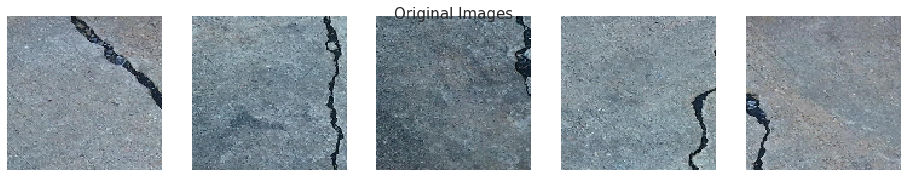

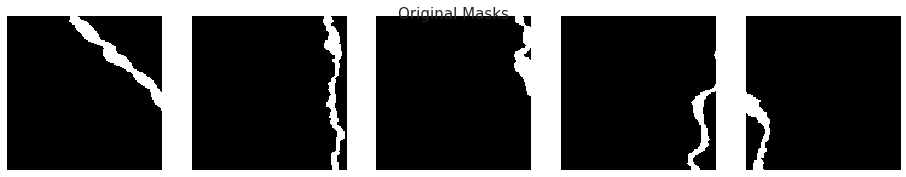

In [14]:
# Validation generator samples (Un-augmented)
for i, j in test1_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [15]:
train_generator = Generator(train_image_files, train_mask_files)
validation_generator = Generator(val_image_files, val_mask_files)


In [16]:
for i, j in train_generator:
  break

print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


In [17]:
for i, j in validation_generator:
  break

print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


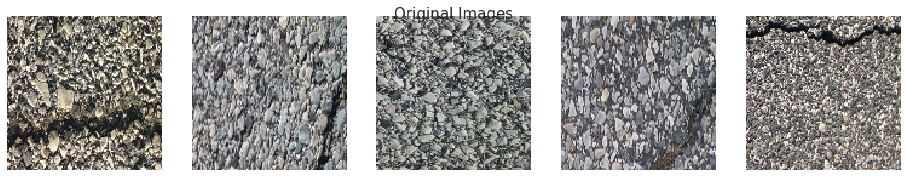

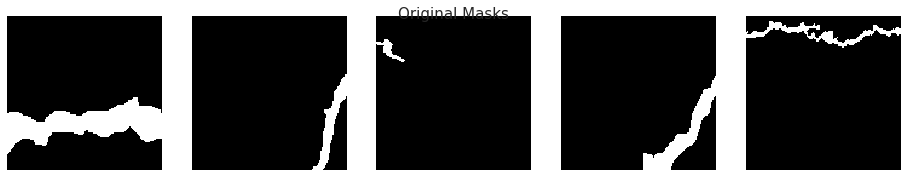

In [18]:
# Train generator samples (Un-augmented)
for i, j in train_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

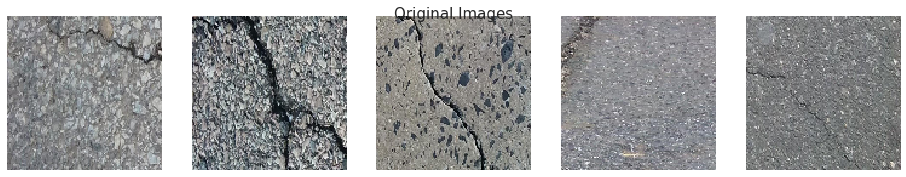

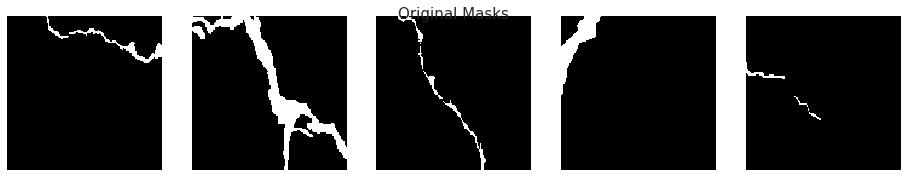

In [19]:
# Validation generator samples (Un-augmented)
for i, j in validation_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [20]:
tg = Generator(train_image_files, train_mask_files, batch_size, img_dim, augment = True)
vg = Generator(val_image_files, val_mask_files, batch_size, img_dim, augment = False)

In [21]:
for i, j in tg:
  break

print(i.shape)
print(j.shape)

(5, 256, 256, 3)
(5, 256, 256, 1)


In [22]:
for i, j in vg:
  break

print(i.shape)
print(j.shape)

(5, 256, 256, 3)
(5, 256, 256, 1)


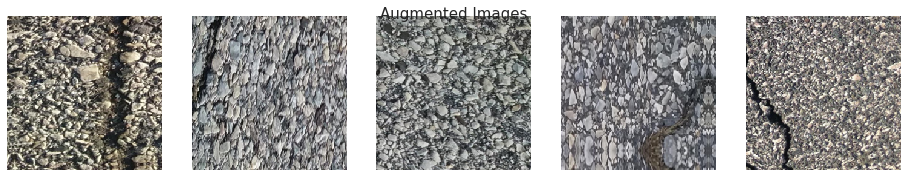

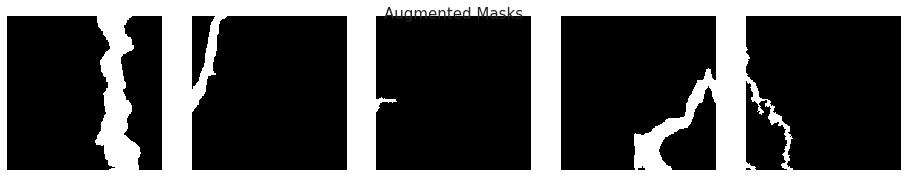

In [23]:
# Augmented train
for i, j in tg:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Augmented Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Augmented Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Model

In [24]:
import numpy as np
from tensorflow.keras.backend import int_shape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Add, BatchNormalization, Input, Activation, Concatenate
from keras.regularizers import l2

Using TensorFlow backend.


In [25]:
# BatchNormalization and Activation
def BN_Act(x, act = True):
    x = BatchNormalization()(x)
    if act == True:
        x = Activation("relu")(x)
    return x

In [26]:
#conv2d block
def conv2d_block(x, filters, kernel_size = (3, 3), padding = "same", strides = 1):
    conv = BN_Act(x)
    conv = Conv2D(filters, kernel_size, padding = padding, strides = strides)(conv)
    return conv

In [27]:
#Fixed layer.
def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding = padding, strides = strides)(x)
    conv = conv2d_block(conv, filters, kernel_size = kernel_size, padding = padding, strides = strides)
    
    #skip
    shortcut = Conv2D(filters, kernel_size = (1, 1), padding = padding, strides = strides)(x)
    shortcut = BN_Act(shortcut, act = False) # No activation in skip connection
    
    output = Add()([conv, shortcut])
    return output

In [28]:
# Residual Block
def residual_block(x, filters, kernel_size = (3, 3), padding = "same", strides = 1):
    res = conv2d_block(x, filters, kernel_size = kernel_size, padding = padding, strides = strides)
    res = conv2d_block(res, filters, kernel_size = kernel_size, padding = padding, strides = 1)
    
    shortcut = Conv2D(filters, kernel_size = (1, 1), padding = padding, strides = strides)(x)
    shortcut = BN_Act(shortcut, act = False) # No activation in skip connection
    
    output = Add()([shortcut, res])
    return output

In [29]:
# Upsampling Concatenation block
def upsample_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    c = Concatenate()([u, xskip])
    return c

In [30]:
# MODEL
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_dim[0], img_dim[1], 3))
    
    ## Encoder/downsampling/contracting path
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides = 2)
    e3 = residual_block(e2, f[2], strides = 2)
    e4 = residual_block(e3, f[3], strides = 2)
    e5 = residual_block(e4, f[4], strides = 2)
    
    ## Bridge/Bottleneck
    b0 = conv2d_block(e5, f[4], strides = 1)
    b1 = conv2d_block(b0, f[4], strides = 1)
    
    ## Decoder/upsampling/expansive path
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = Conv2D(1, (1, 1), padding = "same", activation = "sigmoid")(d4)
    model = Model(inputs, outputs)
    return model

In [31]:
K.clear_session()
model = ResUNet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

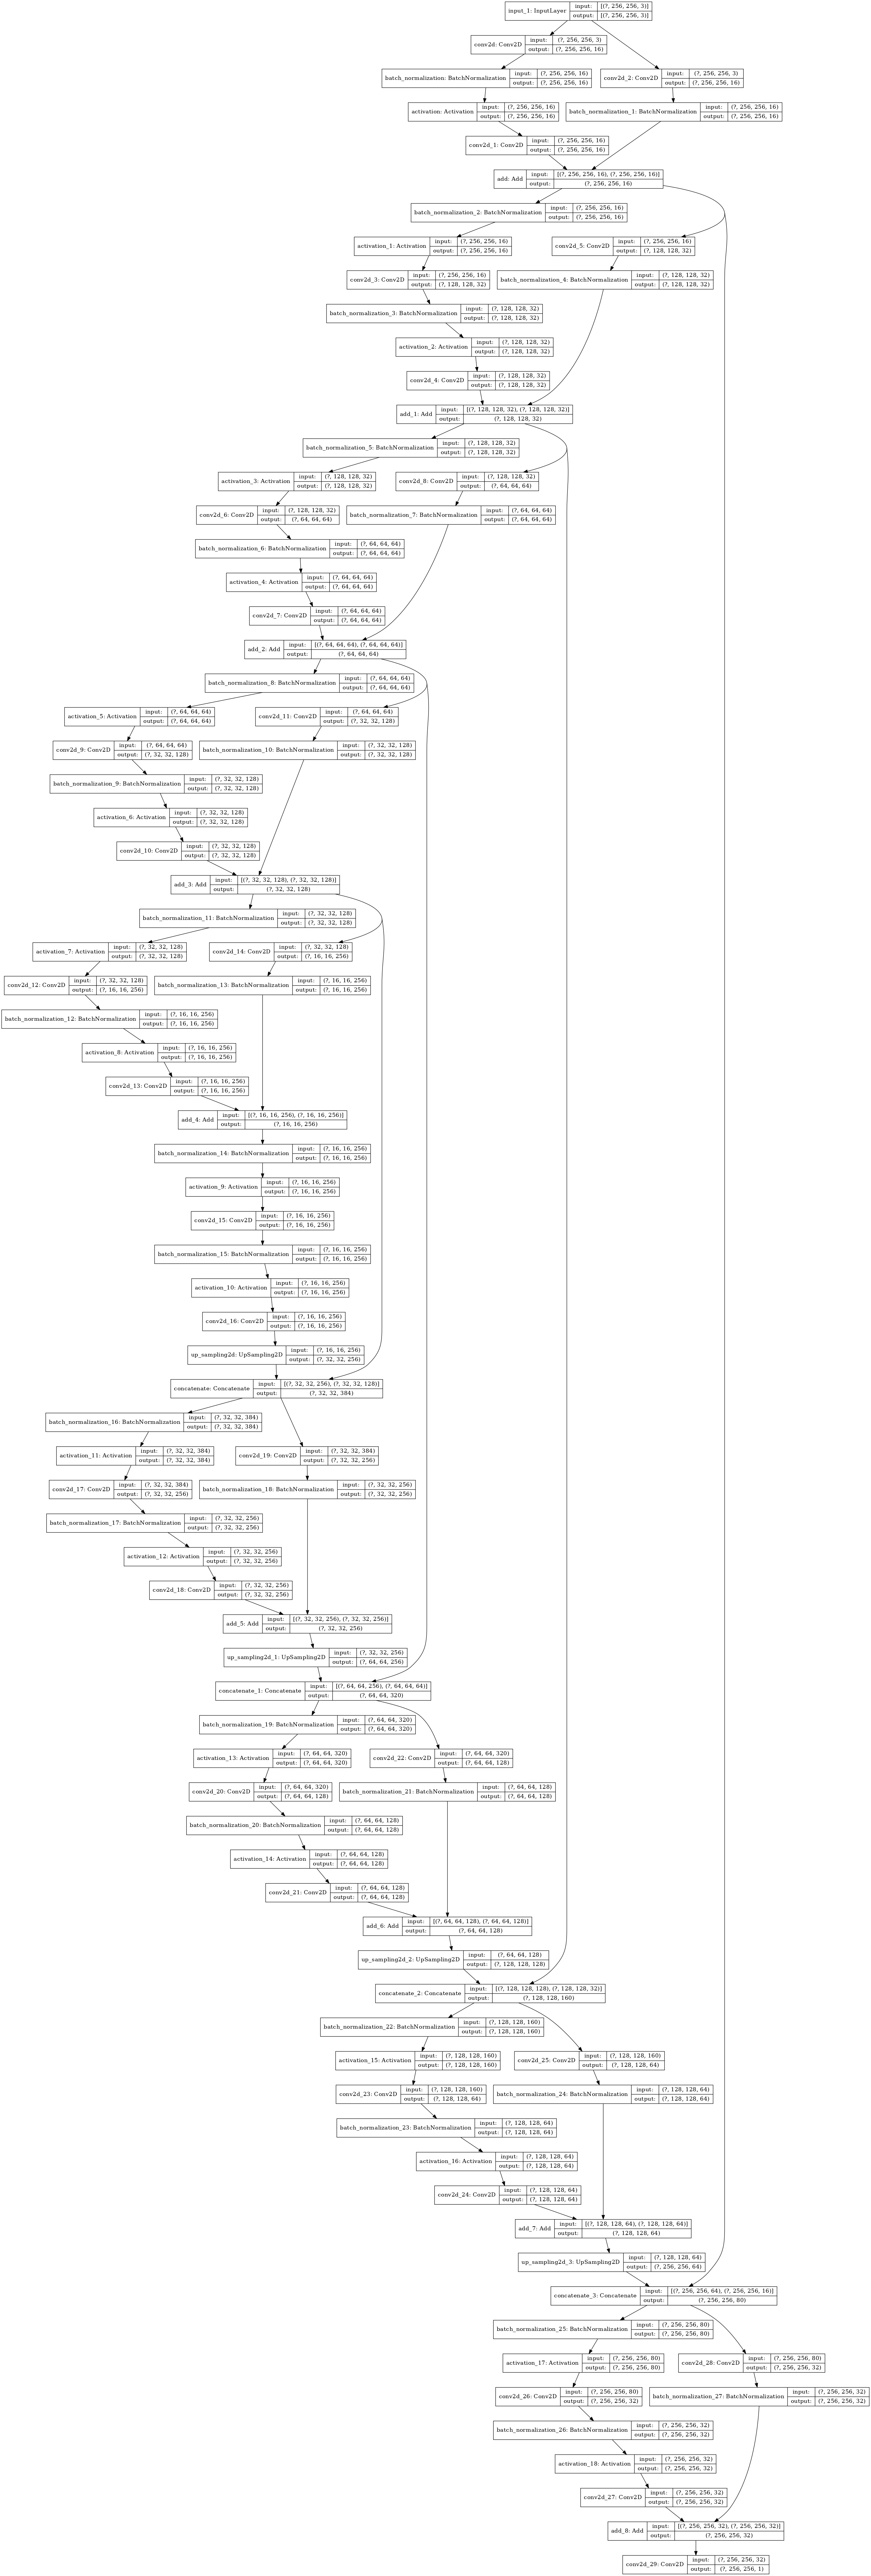

In [33]:
from tensorflow.keras.utils import  plot_model

plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=100,
)

# Loss
# &
# Compile

In [34]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def IOU(y_true, y_pred):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    thresh = 0.5

    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')

    union = K.sum(K.maximum(y_true, y_pred)) + K.epsilon()
    intersection = K.sum(K.minimum(y_true, y_pred)) + K.epsilon()

    iou = intersection/union

    return iou



In [35]:
def lr_schedule(epoch):

    lr =0.0035
    if epoch >150:
        lr *=2**-1
    elif epoch >80:
        lr *=2**(-1)
    elif epoch >50:
        lr *=2**(-1)
    elif epoch >30:
        lr *=2**(-1)
    
    print('Learning rate: ', lr)
    return lr

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD

In [37]:

import time

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]


In [38]:
import tensorflow as tf
optimiser=tf.keras.optimizers.Adam(
    learning_rate=lr_schedule(0),
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="Adam"
)

#from tensorflow.keras.utils import multi_gpu_model
#model = multi_gpu_model(model, gpus=4)

from tensorflow.python.client import device_lib
#from tensorflow.contrib.compiler import xla
device_lib.list_local_devices()


#from tensorflow.keras.utils import multi_gpu_model
#model = multi_gpu_model(model, gpus=4)

model.compile(optimizer =optimiser , loss = dice_coef_loss, metrics = ['accuracy', IOU, dice_coef])

Learning rate:  0.0035


In [39]:
model.save('/data/datasets/crack/Crack500/Adam_and_beyond.h5')

# Training

In [40]:
train_steps = len(train_image_files)//batch_size
valid_steps = len(val_image_files)//batch_size

history = model.fit(
    tg, 
    steps_per_epoch=train_steps,
    initial_epoch = 0,
    epochs=200,
    validation_data = vg,    
    validation_steps = valid_steps,callbacks=callbacks)

Learning rate:  0.0035
Epoch 1/200
300/300 [==============================] - 30s 100ms/step - loss: 0.3929 - acc: 0.9435 - IOU: 0.4525 - dice_coef: 0.6071 - val_loss: 0.5232 - val_acc: 0.9512 - val_IOU: 0.3305 - val_dice_coef: 0.4768
Learning rate:  0.0035
Epoch 2/200
300/300 [==============================] - 23s 77ms/step - loss: 0.3457 - acc: 0.9558 - IOU: 0.4971 - dice_coef: 0.6543 - val_loss: 0.3294 - val_acc: 0.9554 - val_IOU: 0.5138 - val_dice_coef: 0.6706
Learning rate:  0.0035
Epoch 3/200
300/300 [==============================] - 23s 77ms/step - loss: 0.3275 - acc: 0.9585 - IOU: 0.5166 - dice_coef: 0.6725 - val_loss: 0.5179 - val_acc: 0.9344 - val_IOU: 0.3355 - val_dice_coef: 0.4821
Learning rate:  0.0035
Epoch 4/200
300/300 [==============================] - 23s 78ms/step - loss: 0.3183 - acc: 0.9600 - IOU: 0.5268 - dice_coef: 0.6817 - val_loss: 0.2907 - val_acc: 0.9641 - val_IOU: 0.5569 - val_dice_coef: 0.7093
Learning rate:  0.0035
Epoch 5/200
300/300 [===================

Learning rate:  0.0035
Epoch 24/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2590 - acc: 0.9677 - IOU: 0.5955 - dice_coef: 0.7410 - val_loss: 0.2692 - val_acc: 0.9660 - val_IOU: 0.5848 - val_dice_coef: 0.7308
Learning rate:  0.0035
Epoch 25/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2556 - acc: 0.9681 - IOU: 0.6005 - dice_coef: 0.7444 - val_loss: 0.2731 - val_acc: 0.9573 - val_IOU: 0.5846 - val_dice_coef: 0.7269
Learning rate:  0.0035
Epoch 26/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2575 - acc: 0.9676 - IOU: 0.5974 - dice_coef: 0.7425 - val_loss: 0.2587 - val_acc: 0.9686 - val_IOU: 0.5979 - val_dice_coef: 0.7413
Learning rate:  0.0035
Epoch 27/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2598 - acc: 0.9677 - IOU: 0.5951 - dice_coef: 0.7402 - val_loss: 0.2789 - val_acc: 0.9632 - val_IOU: 0.5728 - val_dice_coef: 0.7211
Learning rate:  0.0035
Epoch 28/200
300/300 [===============

300/300 [==============================] - 23s 78ms/step - loss: 0.2435 - acc: 0.9697 - IOU: 0.6153 - dice_coef: 0.7565 - val_loss: 0.2345 - val_acc: 0.9681 - val_IOU: 0.6266 - val_dice_coef: 0.7655
Learning rate:  0.00175
Epoch 47/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2439 - acc: 0.9696 - IOU: 0.6151 - dice_coef: 0.7561 - val_loss: 0.2307 - val_acc: 0.9710 - val_IOU: 0.6318 - val_dice_coef: 0.7693
Learning rate:  0.00175
Epoch 48/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2415 - acc: 0.9699 - IOU: 0.6177 - dice_coef: 0.7585 - val_loss: 0.2338 - val_acc: 0.9696 - val_IOU: 0.6281 - val_dice_coef: 0.7662
Learning rate:  0.00175
Epoch 49/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2400 - acc: 0.9701 - IOU: 0.6196 - dice_coef: 0.7600 - val_loss: 0.2400 - val_acc: 0.9669 - val_IOU: 0.6225 - val_dice_coef: 0.7600
Learning rate:  0.00175
Epoch 50/200
300/300 [==============================] - 23s 78ms/step

300/300 [==============================] - 23s 78ms/step - loss: 0.2362 - acc: 0.9702 - IOU: 0.6246 - dice_coef: 0.7638 - val_loss: 0.2235 - val_acc: 0.9710 - val_IOU: 0.6407 - val_dice_coef: 0.7765
Learning rate:  0.00175
Epoch 70/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2379 - acc: 0.9704 - IOU: 0.6232 - dice_coef: 0.7621 - val_loss: 0.2415 - val_acc: 0.9704 - val_IOU: 0.6182 - val_dice_coef: 0.7585
Learning rate:  0.00175
Epoch 71/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2383 - acc: 0.9699 - IOU: 0.6222 - dice_coef: 0.7617 - val_loss: 0.2331 - val_acc: 0.9696 - val_IOU: 0.6306 - val_dice_coef: 0.7669
Learning rate:  0.00175
Epoch 72/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2369 - acc: 0.9699 - IOU: 0.6233 - dice_coef: 0.7631 - val_loss: 0.2272 - val_acc: 0.9702 - val_IOU: 0.6363 - val_dice_coef: 0.7728
Learning rate:  0.00175
Epoch 73/200
300/300 [==============================] - 23s 78ms/step

Learning rate:  0.00175
Epoch 92/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2299 - acc: 0.9711 - IOU: 0.6326 - dice_coef: 0.7701 - val_loss: 0.2249 - val_acc: 0.9715 - val_IOU: 0.6391 - val_dice_coef: 0.7751
Learning rate:  0.00175
Epoch 93/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2305 - acc: 0.9706 - IOU: 0.6309 - dice_coef: 0.7695 - val_loss: 0.2244 - val_acc: 0.9715 - val_IOU: 0.6398 - val_dice_coef: 0.7756
Learning rate:  0.00175
Epoch 94/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2316 - acc: 0.9707 - IOU: 0.6306 - dice_coef: 0.7684 - val_loss: 0.2287 - val_acc: 0.9704 - val_IOU: 0.6354 - val_dice_coef: 0.7713
Learning rate:  0.00175
Epoch 95/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2351 - acc: 0.9705 - IOU: 0.6264 - dice_coef: 0.7649 - val_loss: 0.2398 - val_acc: 0.9703 - val_IOU: 0.6215 - val_dice_coef: 0.7602
Learning rate:  0.00175
Epoch 96/200
300/300 [==========

300/300 [==============================] - 23s 78ms/step - loss: 0.2302 - acc: 0.9714 - IOU: 0.6321 - dice_coef: 0.7698 - val_loss: 0.2234 - val_acc: 0.9712 - val_IOU: 0.6416 - val_dice_coef: 0.7766
Learning rate:  0.00175
Epoch 115/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2298 - acc: 0.9712 - IOU: 0.6331 - dice_coef: 0.7702 - val_loss: 0.2291 - val_acc: 0.9694 - val_IOU: 0.6344 - val_dice_coef: 0.7709
Learning rate:  0.00175
Epoch 116/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2282 - acc: 0.9713 - IOU: 0.6347 - dice_coef: 0.7718 - val_loss: 0.2419 - val_acc: 0.9666 - val_IOU: 0.6227 - val_dice_coef: 0.7581
Learning rate:  0.00175
Epoch 117/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2337 - acc: 0.9707 - IOU: 0.6281 - dice_coef: 0.7663 - val_loss: 0.2292 - val_acc: 0.9696 - val_IOU: 0.6340 - val_dice_coef: 0.7708
Learning rate:  0.00175
Epoch 118/200
300/300 [==============================] - 23s 78ms/

300/300 [==============================] - 23s 78ms/step - loss: 0.2254 - acc: 0.9718 - IOU: 0.6379 - dice_coef: 0.7746 - val_loss: 0.2349 - val_acc: 0.9704 - val_IOU: 0.6293 - val_dice_coef: 0.7651
Learning rate:  0.00175
Epoch 138/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2279 - acc: 0.9714 - IOU: 0.6349 - dice_coef: 0.7721 - val_loss: 0.2202 - val_acc: 0.9717 - val_IOU: 0.6458 - val_dice_coef: 0.7798
Learning rate:  0.00175
Epoch 139/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2262 - acc: 0.9715 - IOU: 0.6371 - dice_coef: 0.7738 - val_loss: 0.2344 - val_acc: 0.9679 - val_IOU: 0.6311 - val_dice_coef: 0.7656
Learning rate:  0.00175
Epoch 140/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2276 - acc: 0.9714 - IOU: 0.6351 - dice_coef: 0.7724 - val_loss: 0.2396 - val_acc: 0.9696 - val_IOU: 0.6242 - val_dice_coef: 0.7604
Learning rate:  0.00175
Epoch 141/200
300/300 [==============================] - 23s 78ms/

300/300 [==============================] - 23s 78ms/step - loss: 0.2260 - acc: 0.9717 - IOU: 0.6378 - dice_coef: 0.7740 - val_loss: 0.2237 - val_acc: 0.9718 - val_IOU: 0.6410 - val_dice_coef: 0.7763
Learning rate:  0.00175
Epoch 160/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2246 - acc: 0.9716 - IOU: 0.6390 - dice_coef: 0.7754 - val_loss: 0.2272 - val_acc: 0.9712 - val_IOU: 0.6371 - val_dice_coef: 0.7728
Learning rate:  0.00175
Epoch 161/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2264 - acc: 0.9715 - IOU: 0.6365 - dice_coef: 0.7736 - val_loss: 0.2236 - val_acc: 0.9710 - val_IOU: 0.6411 - val_dice_coef: 0.7764
Learning rate:  0.00175
Epoch 162/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2251 - acc: 0.9716 - IOU: 0.6387 - dice_coef: 0.7749 - val_loss: 0.2260 - val_acc: 0.9719 - val_IOU: 0.6384 - val_dice_coef: 0.7740
Learning rate:  0.00175
Epoch 163/200
300/300 [==============================] - 23s 78ms/

300/300 [==============================] - 23s 78ms/step - loss: 0.2236 - acc: 0.9718 - IOU: 0.6404 - dice_coef: 0.7764 - val_loss: 0.2241 - val_acc: 0.9703 - val_IOU: 0.6408 - val_dice_coef: 0.7759
Learning rate:  0.00175
Epoch 183/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2232 - acc: 0.9720 - IOU: 0.6411 - dice_coef: 0.7768 - val_loss: 0.2216 - val_acc: 0.9706 - val_IOU: 0.6436 - val_dice_coef: 0.7784
Learning rate:  0.00175
Epoch 184/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2224 - acc: 0.9722 - IOU: 0.6421 - dice_coef: 0.7776 - val_loss: 0.2212 - val_acc: 0.9718 - val_IOU: 0.6446 - val_dice_coef: 0.7788
Learning rate:  0.00175
Epoch 185/200
300/300 [==============================] - 23s 78ms/step - loss: 0.2202 - acc: 0.9722 - IOU: 0.6449 - dice_coef: 0.7798 - val_loss: 0.2285 - val_acc: 0.9718 - val_IOU: 0.6362 - val_dice_coef: 0.7715
Learning rate:  0.00175
Epoch 186/200
300/300 [==============================] - 23s 78ms/

In [41]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['acc']
valid_acc = history.history['val_acc']

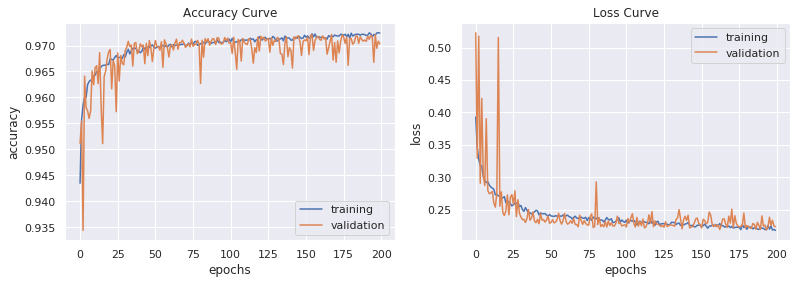

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes = axes.flatten()

axes[0].plot(train_acc, label='training')
axes[0].plot(valid_acc, label='validation')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()


axes[1].plot(train_loss, label='training')
axes[1].plot(valid_loss, label='validation')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.show()

In [43]:
train_dice = history.history['dice_coef']
valid_dice = history.history['val_dice_coef']


train_IOU = history.history['IOU']
valid_IOU = history.history['val_IOU']

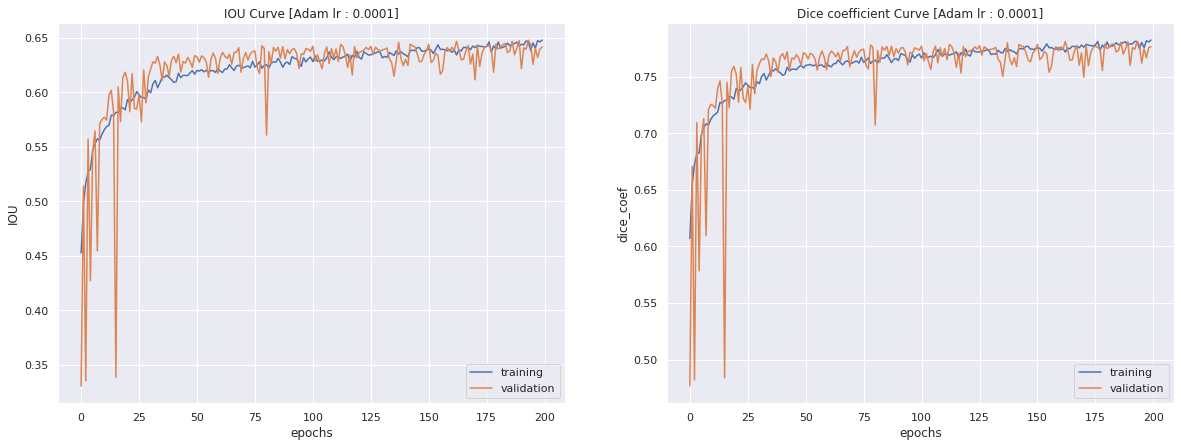

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))
axes = axes.flatten()

axes[0].plot(train_IOU, label='training')
axes[0].plot(valid_IOU, label='validation')
axes[0].set_title('IOU Curve [Adam lr : 0.0001]')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('IOU')
axes[0].legend()


axes[1].plot(train_dice, label='training')
axes[1].plot(valid_dice, label='validation')
axes[1].set_title('Dice coefficient Curve [Adam lr : 0.0001]')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('dice_coef')
axes[1].legend()

plt.show()

In [45]:
# Model save
model.save(model_path)

## Testing

In [46]:
model.load_weights(model_path)

print("Loaded model from disk")

Loaded model from disk


In [47]:
num_val_files = len(val_image_files)
test_generator = Generator(val_image_files, val_mask_files, num_val_files, img_dim)

for x_test, y_test in test_generator:
  break

y_pred = model.predict(x_test)

yy_true = (y_test>0.5).flatten()
yy_pred = (y_pred>0.5).flatten()

In [48]:
report = classification_report(yy_true, yy_pred, output_dict=True)

Accuracy = accuracy_score(yy_true, yy_pred)

AP = average_precision_score(y_test.flatten(), y_pred.flatten())

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

AUC = roc_auc_score(y_test.flatten(), y_pred.flatten())

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)

print("Accuracy: {0:.4f}\n".format(Accuracy))
print("AP: {0:.4f}\n".format(AP))
print("Precision: {0:.4f}\n".format(Precision))
print("Recall: {0:.4f}\n".format(Recall))
print("F1-Score: {0:.4f}\n".format(F1_score))
print("Sensitivity: {0:.4f}\n".format(Sensitivity))
print("Specificity: {0:.4f}\n".format(Specificity))
print("AUC: {0:.4f}\n".format(AUC))
print("IOU: {0:.4f}\n".format(IOU))
print('-'*50,'\n')
print(classification_report(yy_true, yy_pred))

Accuracy: 0.9703

AP: 0.6505

Precision: 0.7653

Recall: 0.8113

F1-Score: 0.7876

Sensitivity: 0.8113

Specificity: 0.9819

AUC: 0.9021

IOU: 0.6496

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       0.99      0.98      0.98  24192634
        True       0.77      0.81      0.79   1759622

    accuracy                           0.97  25952256
   macro avg       0.88      0.90      0.89  25952256
weighted avg       0.97      0.97      0.97  25952256



In [49]:
for i, j in test1_generator:
  break

print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


In [50]:
ttg = Generator(test_image_paths,test_mask_paths, batch_size, img_dim, augment = False)

In [51]:
for i, j in ttg:
  break

print(i.shape)
print(j.shape)

(5, 256, 256, 3)
(5, 256, 256, 1)


In [52]:
num_test_files = len(test_image_paths)
test_generator1 = Generator(test_image_paths,test_mask_paths,num_test_files, img_dim)

for x_test, y_test in test_generator1:
  break

y_pred = model.predict(x_test)

yy_true = (y_test>0.5).flatten()
yy_pred = (y_pred>0.5).flatten()

In [53]:
report = classification_report(yy_true, yy_pred, output_dict=True)

Accuracy = accuracy_score(yy_true, yy_pred)

AP = average_precision_score(y_test.flatten(), y_pred.flatten())

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

AUC = roc_auc_score(y_test.flatten(), y_pred.flatten())

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)

print("Accuracy: {0:.4f}\n".format(Accuracy))
print("AP: {0:.4f}\n".format(AP))
print("Precision: {0:.4f}\n".format(Precision))
print("Recall: {0:.4f}\n".format(Recall))
print("F1-Score: {0:.4f}\n".format(F1_score))
print("Sensitivity: {0:.4f}\n".format(Sensitivity))
print("Specificity: {0:.4f}\n".format(Specificity))
print("AUC: {0:.4f}\n".format(AUC))
print("IOU: {0:.4f}\n".format(IOU))
print('-'*50,'\n')
print(classification_report(yy_true, yy_pred))

Accuracy: 0.9632

AP: 0.5509

Precision: 0.6557

Recall: 0.7963

F1-Score: 0.7192

Sensitivity: 0.7963

Specificity: 0.9737

AUC: 0.8913

IOU: 0.5615

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       0.99      0.97      0.98  69301712
        True       0.66      0.80      0.72   4360752

    accuracy                           0.96  73662464
   macro avg       0.82      0.89      0.85  73662464
weighted avg       0.97      0.96      0.96  73662464

